In [18]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import h5py
import pandas as pd

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import load_datacube as load
import pk_tools as pk
import obs_tools as obs
import fg_tools as fg

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# GPR workshop

In this notebook we go through the main code used to run Gaussian Process Regression for foreground removal on HI Intensity Mapping data. For the most important functions, we walk through them step by step and then also show how to call them from the relevant scripts.

## Loading data

First, we load all the raw data:

- Foregrounds (with polarisation)
- HI cosmological signal
- Instrumental noise

And make sure the data is in $[Nx, Ny, Nz]$ format, where $Nz$ is the line of sight (frequency) direction. The data is smoothed by a constant telescope beam, which is the largest beam given by the beam size at the highest redshift ($z=0.58$).

We also load the frequency range of our data, `freqs`. The data goes from 1183MHz to 899MHz in 1MHz increments.

In [3]:
data = h5py.File('../Data/data.h5', 'r')
FGwpol_HI_noise_data = data.get('beam/FGwpol+HI+noise')[()]
#FGnopol_data = data.get('beam/foregrounds/sync')[()] + data.get('beam/foregrounds/free')[()] + data.get('beam/foregrounds/psource')[()]
HI_noise_data = data.get('beam/HI+noise')[()]
freqs = data.get('freqs')[()]

Now we run PCA foreground cleaning in order to compare these results to GPR:

In [4]:
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

## Running GPR

We start by choosing which kernels we will use for each component in our data:

In [5]:
# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.RBF(1)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.RBF(1)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

We want to set priors for the kernels, to make sure the foreground kernels aren't fitting to the HI data and the HI kernel isn't fitting to the foregrounds.
Since larger lengthscales mean "smoother" line of sight functions, we want the lengthscale for the foreground kernels to be large and for the HI kernel to be smaller.
We don't do this for the smooth foreground because for that we are using the Polynomial kernel, which doesn't have a lengthscale parameter.

In [6]:
# setting lengthscale prior to be between 0-20MHz for HI data:
kern_21.lengthscale.constrain_bounded(0,15)
# setting priors for the smooth foreground kernel:
kern_fg.rbf.variance.constrain_bounded(1000,10000000)
kern_fg.rbf.lengthscale.constrain_bounded(200,1000)
# setting priors for the polarised foreground kernel:
kern_fg.rbf_1.variance.constrain_bounded(0,10)
kern_fg.rbf_1.lengthscale.constrain_bounded(15,500)

reconstraining parameters Exponential.lengthscale
reconstraining parameters sum.rbf.variance
reconstraining parameters sum.rbf.lengthscale
reconstraining parameters sum.rbf_1.variance
reconstraining parameters sum.rbf_1.lengthscale


Parameters for running GPR:

- `Input`: data cube to be cleaned, in $[Nx,Ny,Nz]$ format where $Nz$ is the frequency direction
- `num_restarts`: how many times to optimise the GPR regression model by restarting the GPR fit
- `NprePCA`: set to 0 if no pre-PCA is desired, otherwise this number is the $N_\text{FG}$ number of components used in a pre-PCA clean of the data
- `noise_data`: input here your noise map in $[Nx,Ny,Nz]$ if you have a reasonable estimate from your data, otherwise set to None and use GPR to try to fit your noise
- `zero_noise`: if True, the noise in your GPR model will be set to zero and fixed. Otherwise it will try to fit to noise in your data, in either the heteroscedastic or non-heteroscedastic case. Set to zero if you want to fit your noise with a separate kernel instead, otherwise you will fit to noise twice
- `heteroscedastic`: if True, runs Heteroscedastic regression model (where the noise variance changes with frequency) (Note: you cannot have noise=False and heteroscedastic=True at the same time, to set noise to zero set heteroscedastic=False too). If False, the noise variance will be assumed to be constant with frequency.
- `invert`: if True, inverts data in the frequency direction

In [8]:
Input = FGwpol_HI_noise_data
num_restarts = 10
NprePCA = 0
noise_data = None
zero_noise = True
heteroscedastic = False
invert = False

Prepare the data for running GPR:

In [9]:
# extract axes from the data:
axes = np.shape(Input)
    
# if desired, do a pre-PCA with N_FG=NprePCA removed components
if NprePCA > 0: Input = fg.PCAclean(Input, N_FG=NprePCA)[0]

# converting data format to LoS pixels [Nx,Ny,Nz] -> [Npix,Nz]
Input = load.LoSpixels(Input)
if noise_data is not None: noise_data = load.LoSpixels(noise_data)

# invert frequency axis
if invert==True: 
    Input = Input[::-1]
    if noise_data is not None: noise_data = noise_data[::-1]

Next, we build our GPR model using our frequency rance, input data and kernel. This will look different depending on the choices made for the parameters, e.g. whether the noise is fixed and whether the model is heteroscedastic.

In [10]:
# build your model, input the freq range, the data, and the kernels
kern = kern_fg + kern_21
    
# this heteroscedastic case assumes a Gaussian noise variance that changes with frequency
if heteroscedastic==True: 
    # this case assumes noise is known, sets noise level to your noise_data variances
        # at different frequencies (since heteroscedastic)
    if noise_data is not None:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
        model.het_Gauss.variance.constrain_fixed(noise_data.var(axis=1)[:, None])
        #model.het_Gauss.variance.constrain_bounded(noise_data[0], noise_data[1])
    # this case assumes noise is not known, model will fit a variance at each frequency
    else:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
    # note: if you want the case of *no noise*, there's no need to use heteroscedastic,
        # so set heteroscedastic = False and see below

# this non-heteroscedastic case assumes constant Gaussian noise variance throughout frequency
else: 
    # this case assumes noise is know, sets the noise variance level to the variance
        # from the input noise_data
    if noise_data is not None:
        model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
        model.Gaussian_noise.constrain_fixed(noise_data.var())
    else:
        # this case assumes there is no noise in your data
        if zero_noise == True:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
            model['.*Gaussian_noise'] = 0.0
            model['.*noise'].fix()
        # this case assumes there is noise but it is unknown, fits a constant variance
        else:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)

Now that we have the model, we optimise it and find the best fitting hyperparameters for the kernels:

In [11]:
model.optimize_restarts(num_restarts = num_restarts)

 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -45836973.57973343
Optimization restart 2/10, f = -46037042.688421175
Optimization restart 3/10, f = -46274836.63096298
Optimization restart 4/10, f = -46223365.27557928
Optimization restart 5/10, f = -46223482.1840591
Optimization restart 6/10, f = -46274837.02259345
Optimization restart 7/10, f = -46274836.70810301
Optimization restart 8/10, f = -46176995.01758173
Optimization restart 9/10, f = -45836979.90022254
Optimization restart 10/10, f = -45033521.3087926


We can print the optimised model to see things such as the objective function (which we want to be as small as possible), and also the best fit hyperparameters for the kernels. The `Objective` parameter describes how good of a fit our model is, and we want this to be as small as possible (i.e., a large negative number). You can extract the objective value directly from the model by printing: `model.objective_function()`

In [16]:
model

GP_regression.,value,constraints,priors
sum.rbf.variance,67168.01908505714,"1000.0,10000000.0",
sum.rbf.lengthscale,475.2784103125158,"200.0,1000.0",
sum.rbf_1.variance,0.4993467295313681,"0.0,10.0",
sum.rbf_1.lengthscale,58.41691071238476,"15.0,500.0",
sum.Exponential.variance,0.0012143398609285997,+ve,
sum.Exponential.lengthscale,6.725454494515181,"0.0,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


Now that we have the optimised model, we can use the best fit hyperparamers found for the foreground kernels and use it to "predict" a sample of the foregrounds in our frequency range, and then subtract that prediction from our input data. This is the process of foreground removal with GPR, and should leave us with an estimate for the HI cosmological signal and noise.

In [19]:
# extract optimised foreground kernel:
if kern_fg.name == 'sum': # if there is more than one foreground kernel
    k_fg_length = len(kern_fg.parts)
    k_fg = model.kern.parts[0]
    if k_fg_length > 1:
        for i in range(1, k_fg_length):
            k_fg += model.kern.parts[i]
else: k_fg = model.kern.parts[0]

# make prediction of what FGs would look like using this optimised FG kernel:
fg_fit, fg_cov = model.predict(freqs[:, np.newaxis], full_cov=True, kern=k_fg,
    include_likelihood=False)

# subtract FG fit from data, to obtain HI+noise residuals:
gpr_res = Input - fg_fit

# un-invert data:
if invert==True: 
    gpr_res = gpr_res[::-1]
    fg_fit = fg_fit[::-1]
    
# reshape residuals back to [Nx, Ny, Nz]
gpr_res = np.swapaxes(gpr_res,0,1)
gpr_res = np.reshape(gpr_res,(axes[0], axes[1], axes[2]))

# also reshape foreground fit
fg_fit = np.swapaxes(fg_fit,0,1)
fg_fit = np.reshape(fg_fit,(axes[0], axes[1], axes[2]))

# create Series as the output object, containing all the important results
d = {'res': gpr_res, 'fgcov': fg_cov, 'fgfit': fg_fit, 'model': model}
gpr_result = pd.Series(d)

Let's try to understand this a bit better. Here, what we did was generate a sample of what the foregrounds look like given the best fitting foreground kernel (expectation value, `fg_fit`), and then subtracted this prediction to obtain the residual, which should contain the HI cosmological signal and the noise. We also, while calculating the expectation value, calculated the covariance (`fg_cov`), which can be thought of as the "error" on the expectation value, given by the fact that the kernel isn't a perfect fit to our data.

We use a bias correction to account for the error in our foreground fit. See the notebook `bias_correction.ipynb` for more details on that. We do this when we calculate the power spectrum of the GPR residual, by calling the function `get_biascorr`.

---

And that's how you run foreground removal with GPR! This can all be done by calling a single function, "GPRclean", from the script "fg_tools." Below shows how this can be done. Recall the parameters we chose:

In [20]:
Input = FGwpol_HI_noise_data
num_restarts = 10
NprePCA = 0
noise_data = None
zero_noise = True
heteroscedastic = False
invert = False

# kernels (same as before):
# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.RBF(1)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.RBF(1)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
kern_fg.rbf.variance.constrain_bounded(1000,10000000)
kern_fg.rbf.lengthscale.constrain_bounded(200,1000)
kern_fg.rbf_1.variance.constrain_bounded(0,10)
kern_fg.rbf_1.lengthscale.constrain_bounded(15,500)
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)
kern_21.lengthscale.constrain_bounded(0,15)

reconstraining parameters sum.rbf.variance
reconstraining parameters sum.rbf.lengthscale
reconstraining parameters sum.rbf_1.variance
reconstraining parameters sum.rbf_1.lengthscale
reconstraining parameters Exponential.lengthscale


Calling the `GPRclean` function:

In [21]:
gpr_result2 = fg.GPRclean(Input, freqs, kern_fg, kern_21, NprePCA=NprePCA,
                                          noise_data=noise_data, heteroscedastic=heteroscedastic, 
                                          zero_noise=zero_noise, invert=invert)

 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -45836974.67435486
Optimization restart 2/10, f = -46173945.93922056
Optimization restart 3/10, f = -45836979.04170451
Optimization restart 4/10, f = -45836980.14206732
Optimization restart 5/10, f = -45836975.51026857
Optimization restart 6/10, f = -45836850.77972551
Optimization restart 7/10, f = -46036751.16867937
Optimization restart 8/10, f = -45836977.14224945
Optimization restart 9/10, f = -45836975.25971052
Optimization restart 10/10, f = -46274837.09425098


In [22]:
gpr_result2.model

GP_regression.,value,constraints,priors
sum.rbf.variance,67166.68200948546,"1000.0,10000000.0",
sum.rbf.lengthscale,475.28866387170444,"200.0,1000.0",
sum.rbf_1.variance,0.4992956644764306,"0.0,10.0",
sum.rbf_1.lengthscale,58.41603838984438,"15.0,500.0",
sum.Exponential.variance,0.0012143279960818779,+ve,
sum.Exponential.lengthscale,6.7253971362945535,"0.0,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


To summarise the outputs:

- `gpr_res` (a.k.a. `gpr_result.res`): residual map of HI and noise, after GPR foreground subtraction;
- `fg_fit` (a.k.a. `gpr_result.fgfit`): GPR's prediction for what our foregrounds look like, i.e. what we subtract from our original data to get `gpr_res`;
- `fg_cov` (a.k.a. `gpr_result.fgcov`): error covariance of the foreground estimate, i.e. how uncertain the estimate of the foreground is;
- `model` (a.k.a. `gpr_result.model`): summary of what the best fit hyperparameters were found for the kernels, and what the objective function is.

If you want, you can print the model again to make sure it's similar to the first model. We plot the power spectra of both `gpr_res` and `gpr_res2` below to show that they are consistent.

## Plot power spectrum

In [23]:
# Grid dimension of data cube:
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
nx,ny,nz = 256, 256, 285

# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1

# set width of k bins to be 2*kmin
dk = 2*kmin

# number of k bins:
nkbin = int((kmax-kmin)/dk)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)

# setting array of k bin centers"
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)

Calculate bias correction to the 3D power spectrum only:

In [25]:
n_samples = 10
pk_corr = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, kbins, kbins, w, W)[0]
pk_corr2 = pk.get_biascorr(gpr_result2.fgcov, Input, n_samples, lx, ly, lz, kbins, kbins, w, W)[0]

Calculate 3D power spectra:

In [27]:
pk_HI = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_GPR = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk_corr
pk_GPR2 = pk.getpk(gpr_result2.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk_corr2
pk_PCA3 = pk.getpk(pca_res_7,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Text(0.5, 0, '$k$ [$h$/Mpc]')

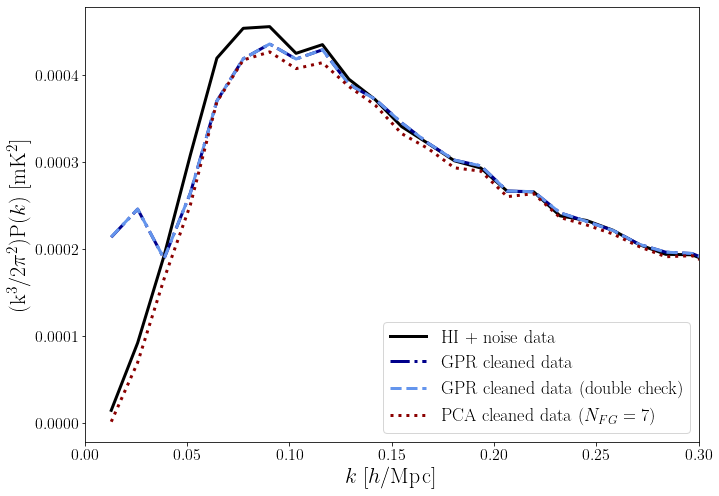

In [28]:
plt.figure(figsize=(11,8))

plt.plot(k, (k*k*k*pk_HI)/(2*np.pi*np.pi), ls='solid', lw=3, c='k', label = r'HI + noise data')
plt.plot(k, (k*k*k*pk_GPR)/(2*np.pi*np.pi), ls='dashdot', lw=3, c='darkblue', label = r'GPR cleaned data')
plt.plot(k, (k*k*k*pk_GPR2)/(2*np.pi*np.pi), ls='dashed', lw=3, c='cornflowerblue', label = r'GPR cleaned data (double check)')
plt.plot(k, (k*k*k*pk_PCA3)/(2*np.pi*np.pi), ls='dotted', lw=3, c='darkred', label = r'PCA cleaned data ($N_{FG}=7$)')

plt.legend(fontsize=18)
plt.xlim(0,0.3)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)
plt.xlabel('$k$ [$h$/Mpc]', fontsize=22)